### Import Libraries

In [1]:
# Install necessary libraries
!pip install torch torchvision numpy matplotlib pillow seaborn scikit-learn



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\shuva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import torchvision.transforms as T
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE


### Device Configuration

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define the Grad-CAM Function

In [4]:

def apply_grad_cam(model, input_image_path, target_layer="features.14"):
    input_image = Image.open(input_image_path).convert("RGB")
    preprocess = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(input_image).unsqueeze(0).to(device)

    activations = None
    gradients = []

    def save_activations_and_gradients(module, input, output):
        nonlocal activations
        activations = output
        output.register_hook(lambda grad: gradients.append(grad))

    layer = dict([*model.named_modules()])[target_layer]
    layer.register_forward_hook(save_activations_and_gradients)

    model.eval()
    outputs = model(input_tensor)
    target_class = outputs.argmax(dim=1).item()
    outputs[0].backward()

    if gradients:
        pooled_grads = torch.mean(gradients[0], dim=[0, 2, 3])

        for i in range(pooled_grads.shape[0]):
            activations[:, i, :, :] *= pooled_grads[i]

        heatmap = torch.mean(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap.detach().numpy(), 0)
        heatmap /= heatmap.max() if heatmap.max() > 0 else 1

        heatmap = np.array(Image.fromarray(np.uint8(heatmap * 255)).resize((224, 224)))

        plt.imshow(input_image)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.colorbar()
        plt.show()


### Define Helper Functions for Plotting

In [5]:
# Plotting function for training and validation metrics
def plot_train_validation_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 7))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train and Validation Accuracy')

    plt.show()

# Confusion matrix plot
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# t-SNE visualization
def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab20')
    plt.colorbar(scatter, ticks=range(len(set(labels))))
    plt.title('t-SNE Visualization of Feature Space')
    plt.show()


### Model and Data Preparation

In [6]:

mobilenet_model = models.mobilenet_v2(weights="IMAGENET1K_V1")
mobilenet_model.classifier[1] = nn.Sequential(
    nn.Linear(mobilenet_model.classifier[1].in_features, 1),
    nn.Dropout(0.5), 
    nn.Sigmoid()
)

mobilenet_model = mobilenet_model.to(device)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dir = 'train/' 
test_dir = 'test/'
full_train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32)

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Testing samples: {len(test_data)}")


Training samples: 3786, Validation samples: 947, Testing samples: 1184


### Training Loop and Validation

Epoch [1/10], Train Loss: 0.3889, Train Accuracy: 74.62%, Validation Loss: 0.0646, Validation Accuracy: 98.52%
Epoch [2/10], Train Loss: 0.3676, Train Accuracy: 76.33%, Validation Loss: 0.0546, Validation Accuracy: 98.52%
Epoch [3/10], Train Loss: 0.3634, Train Accuracy: 76.44%, Validation Loss: 0.0461, Validation Accuracy: 98.31%
Epoch [4/10], Train Loss: 0.3630, Train Accuracy: 76.12%, Validation Loss: 0.0429, Validation Accuracy: 98.94%
Epoch [5/10], Train Loss: 0.3542, Train Accuracy: 77.28%, Validation Loss: 0.0427, Validation Accuracy: 98.94%
Epoch [6/10], Train Loss: 0.3521, Train Accuracy: 76.97%, Validation Loss: 0.0386, Validation Accuracy: 98.94%
Epoch [7/10], Train Loss: 0.3510, Train Accuracy: 77.07%, Validation Loss: 0.0304, Validation Accuracy: 98.84%
Epoch [8/10], Train Loss: 0.3432, Train Accuracy: 76.68%, Validation Loss: 0.0410, Validation Accuracy: 98.94%
Epoch [9/10], Train Loss: 0.3570, Train Accuracy: 76.41%, Validation Loss: 0.0556, Validation Accuracy: 98.20%
E

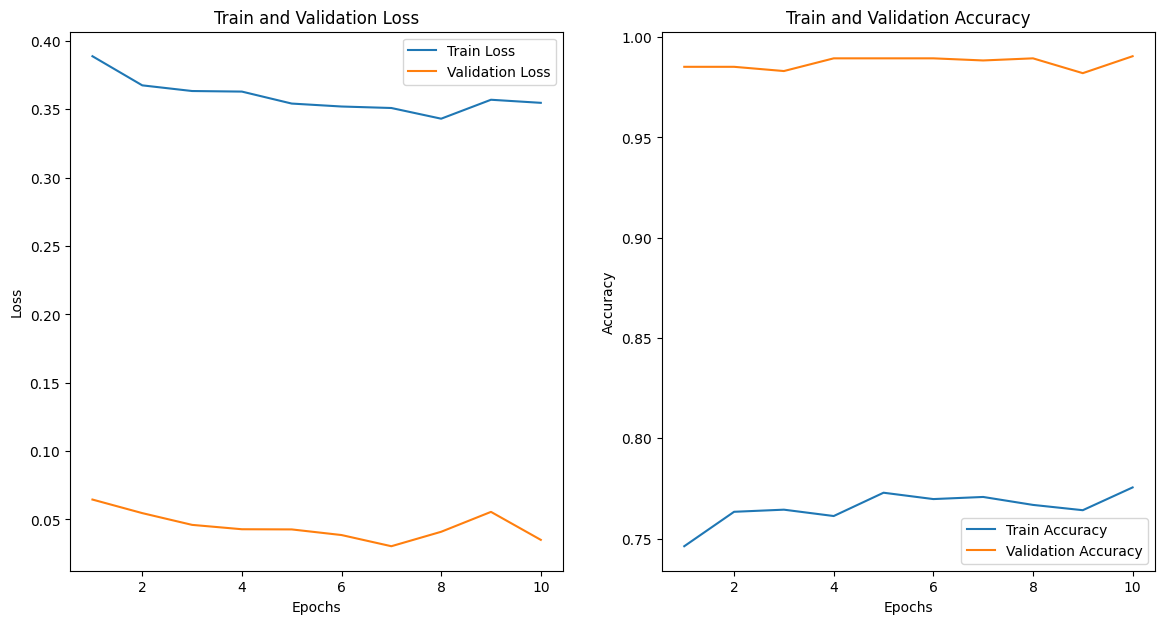

In [7]:

criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):

    mobilenet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        
        outputs = mobilenet_model(images) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_losses.append(running_loss / total_train)
    train_accuracies.append(correct_train / total_train)

    mobilenet_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = mobilenet_model(images) 
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_losses.append(val_loss / total_val)
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]*100:.2f}%, "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]*100:.2f}%")

plot_train_validation_curves(train_losses, train_accuracies, val_losses, val_accuracies)


### Evaluate Model and Plot Confusion Matrix

C:\Users\shuva\AppData\Local\Temp\ipykernel_18556\72131459.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(pred) for pred in all_preds]
C:\Users\shuva\AppData\Local\Temp\ipykernel_18556\72131459.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = [int(label) for label in all_labels]


Accuracy: 99.49%
Precision: 99.49%
Recall: 99.49%
F1 Score: 99.49%


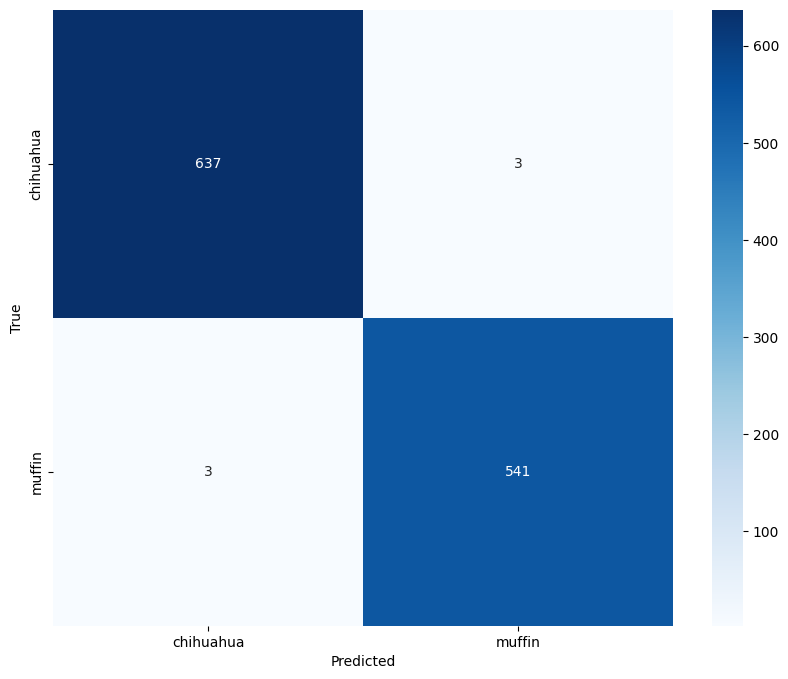

In [8]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)
        outputs = mobilenet_model(images)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_pred = [int(pred) for pred in all_preds]
y_true = [int(label) for label in all_labels]


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

plot_confusion_matrix(all_labels, all_preds, classes=test_data.classes)

### Feature Extraction for t-SNE Visualization

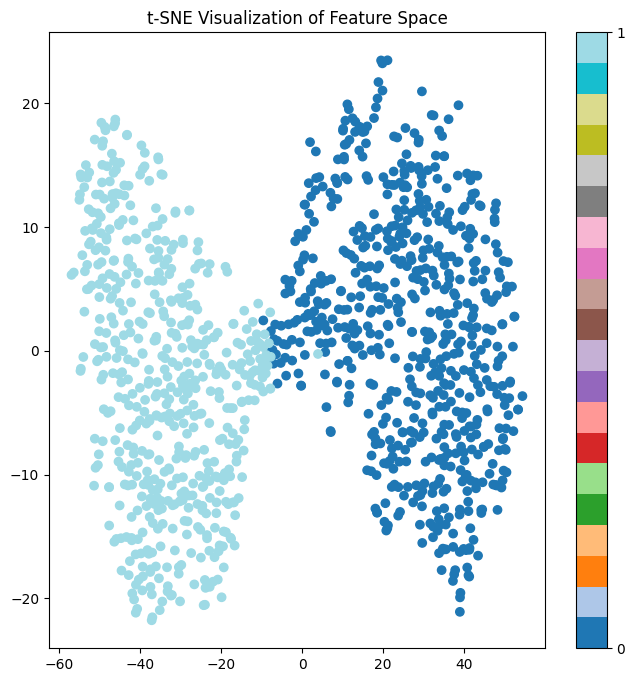

In [9]:

features = []
labels = []
with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to(device)
        output = mobilenet_model.features(images).view(images.size(0), -1)
        features.extend(output.cpu().numpy())
        labels.extend(lbls.numpy())

features = np.array(features)
labels = np.array(labels)

plot_tsne(features, labels)


### Apply Grad-CAM on Sample Images

Grad-CAM for Chihuahua Image:


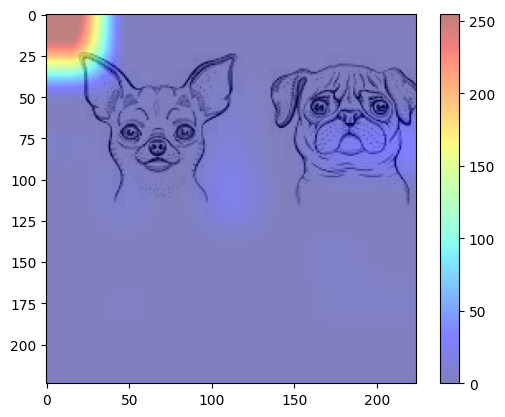

Grad-CAM for Muffin Image:


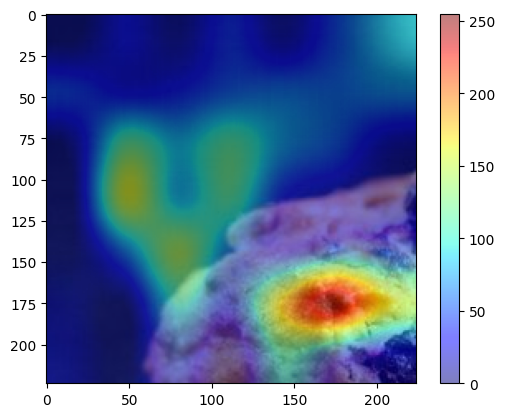

In [10]:
# Applying Grad-CAM to sample images
sample_chihuahua_image = 'test/chihuahua/img_0_5.jpg'
sample_muffin_image = 'test/muffin/img_4_1074.jpg'

print("Grad-CAM for Chihuahua Image:")
apply_grad_cam(mobilenet_model, sample_chihuahua_image)

print("Grad-CAM for Muffin Image:")
apply_grad_cam(mobilenet_model, sample_muffin_image)


In [11]:
print(f"Total training images: {len(train_data)}")
print(f"Total testing images: {len(test_data)}")


Total training images: 3786
Total testing images: 1184
